In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#Logger
import pandas as pd
import numpy as np

expLog_R = pd.DataFrame(columns=["exp_name", 
                               "Loss", 
                               "Accuracy"
                              ])

# Load Training Data

In [5]:
#Train Data Loader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def trainload(batch_size_train):
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/cat_dog/train/",
                                                                                transform = torchvision.transforms.Compose([
                                                                                        torchvision.transforms.Resize((128, 128)),            
                                                                                        torchvision.transforms.ToTensor(),
                                                                                        torchvision.transforms.Normalize(
                                                                                        mean = mean, std = std)
                                                                            ])) , batch_size = batch_size_train, shuffle = True)
    return train_loader

# Load Testing Data

In [6]:
#Test Data Loader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def testload(batch_size_train):
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/cat_dog/test/",
                                                                                      transform = torchvision.transforms.Compose([  
                                                                                      torchvision.transforms.Resize((128, 128)),           
                                                                                      torchvision.transforms.ToTensor(),
                                                                                      torchvision.transforms.Normalize(
                                                                                      mean = mean, std = std)
                                                                            ])), batch_size = batch_size_train, shuffle = True)
    return test_loader

# Create a CNN model

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define 1st layer
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 3, 
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding= 2,
            ),
            torch.nn.ReLU(),
            # torch.nn.LogSoftmax(),
            torch.nn.MaxPool2d(kernel_size = 2),            
        )
        
        # Define 2nd layer
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding= 2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2) ,          
        )
        
        # Define a fully connected layer 
        self.fc1 = torch.nn.Linear(32*32*32, 5000)  # # 512*8*8 # 32*32*32 
        # print(self.fc1)
        # Define a fully connected layer 
        self.fc2 = torch.nn.Linear(5000, 500)
        # print(self.fc2)
        self.fc3 = torch.nn.Linear(500, 2)
        # print(self.fc3)
        # self.fc4 = torch.nn.Linear(50, 2)
        # print(self.fc3)
        # self.fc5 = torch.nn.Linear(50, 2)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Flatten the output 
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        #x = x.view(x.size(0), -1)
        output = self.fc2(x)
        output = torch.nn.functional.log_softmax(output, dim=1)
        #print(output,x)
        return output, x

# Train the CNN model

In [8]:
# Train your model                
def train(num_epochs, cnn, train_loader, test_loader, mini_batch):
    total_train_time = 0
    total_step = len(train_loader)
    train_loss, test_accuracy = [], []
    count = 0
    for epoch in range(num_epochs):
        start = time.time()
        cnn.train()
        total_train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = torch.autograd.Variable(images)
            labels = torch.autograd.Variable(labels)
            count += images.size(0)
            if device.type == "cuda":
                images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            pred = cnn(images)[0]
            
            loss = loss_func(pred, labels)
            
            # Do not optimize for epoch 0
            if epoch > 0:
                loss.backward()
                optimizer.step()
            # Track the loss
            total_train_loss += loss.item()
            if count % 2000 != 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                train_loss.append(total_train_loss/(i+1))
        epoch_train_time = time.time() - start
        total_train_time += epoch_train_time
        print("Epoch Train Time: {:.2f} secs".format(epoch_train_time))
        test_accuracy = test(cnn, test_loader, test_accuracy)
    plot_model(train_loss, test_accuracy)
    print("Total Train Time: {:.2f} mins".format(total_train_time/60))
    return train_loss, test_accuracy
    
# Track the test accuracy
def test(cnn, test_loader, test_accuracy):
    cnn.eval()
    accuracy = 0
    count = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            count += images.size(0)
            if device.type == "cuda":
                images, labels = images.to("cuda"), labels.to("cuda")
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            if count % 2000 != 0:
                test_accuracy.append(accuracy * 100.0)
    print("test_accuracy= ",test_accuracy[-1])
    return test_accuracy

# Plot the traning loss and testing accuracy
def plot_model(train_loss, test_accuracy):
    plt.figure(1, figsize=(15, 8))
    plt.plot(train_loss, label = "Training Loss", linewidth = 2.5)
    plt.ylabel("Cross Entropy Loss")
    plt.grid()
    plt.legend()
    plt.figure(2)
    plt.figure(figsize=(15,8))
    plt.plot(test_accuracy, label = "Testing Accuracy", linewidth = 2.5)
    plt.ylabel("Testing Accuracy in %")
    plt.grid()
    plt.legend()

# Model 1

Epoch [1/30], Step [1/3], Loss: 6.2015
Epoch [1/30], Step [2/3], Loss: 6.1896
Epoch [1/30], Step [3/3], Loss: 6.2129
Epoch Train Time: 26.26 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/3], Loss: 6.1998
Epoch [2/30], Step [2/3], Loss: 5.5873
Epoch [2/30], Step [3/3], Loss: 4.4518
Epoch Train Time: 0.57 secs
test_accuracy=  43.47826086956522
Epoch [3/30], Step [1/3], Loss: 1.4402
Epoch [3/30], Step [2/3], Loss: 0.7330
Epoch [3/30], Step [3/3], Loss: 3.0893
Epoch Train Time: 0.53 secs
test_accuracy=  56.52173913043478
Epoch [4/30], Step [1/3], Loss: 5.2821
Epoch [4/30], Step [2/3], Loss: 4.7617
Epoch [4/30], Step [3/3], Loss: 2.3485
Epoch Train Time: 0.51 secs
test_accuracy=  65.21739130434783
Epoch [5/30], Step [1/3], Loss: 0.6525
Epoch [5/30], Step [2/3], Loss: 0.9387
Epoch [5/30], Step [3/3], Loss: 2.8728
Epoch Train Time: 0.48 secs
test_accuracy=  43.47826086956522
Epoch [6/30], Step [1/3], Loss: 1.6646
Epoch [6/30], Step [2/3], Loss: 0.7794
Epoch [6/30], Step [3/3], Loss: 0.9253
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522


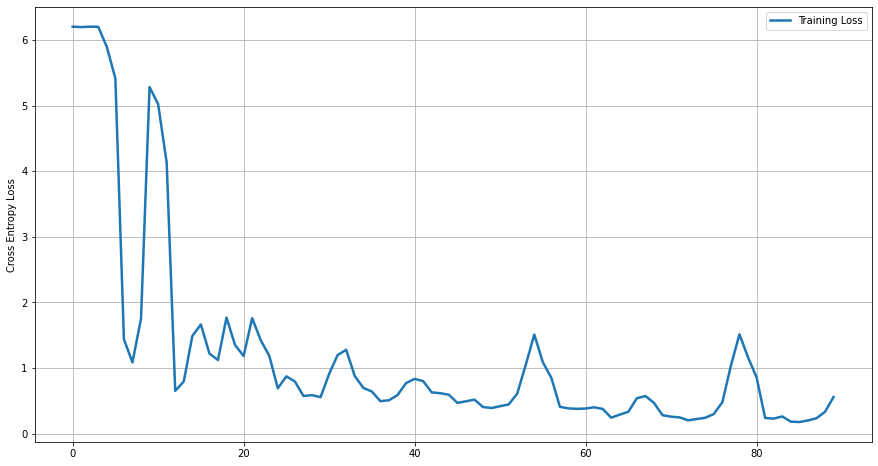

<Figure size 432x288 with 0 Axes>

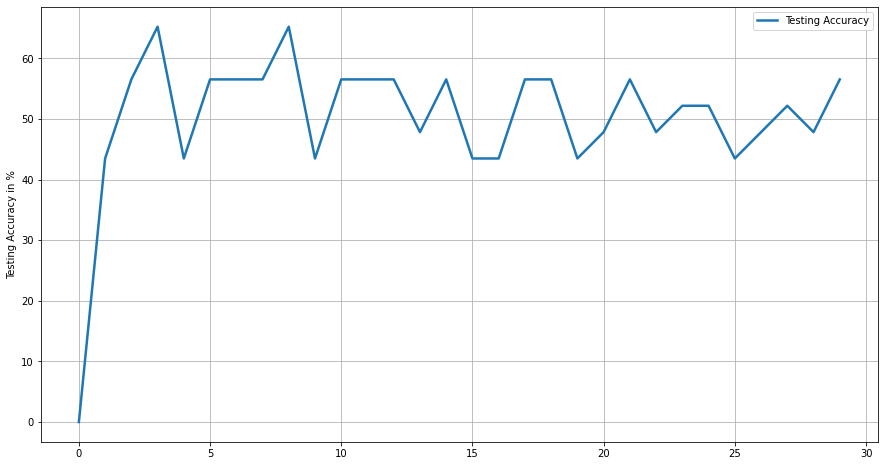

In [10]:
# Download the training and testing data
mini_batch = 30
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn1 = CNN()
if device.type == "cuda":
    cnn1.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn1.parameters(), lr = 0.01)

# Train the model
num_epochs = 30
train_loss, test_accuracy = train(num_epochs, cnn1, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 30, mini_batch=30"
expLog_R.loc[0,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R


# Model 2

Epoch [1/30], Step [1/4], Loss: 6.1968
Epoch [1/30], Step [2/4], Loss: 6.1972
Epoch [1/30], Step [3/4], Loss: 6.2051
Epoch [1/30], Step [4/4], Loss: 6.1895
Epoch Train Time: 0.33 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/4], Loss: 6.2113
Epoch [2/30], Step [2/4], Loss: 5.4449
Epoch [2/30], Step [3/4], Loss: 4.0893
Epoch [2/30], Step [4/4], Loss: 1.1411
Epoch Train Time: 0.63 secs
test_accuracy=  33.33333333333333
Epoch [3/30], Step [1/4], Loss: 0.6393
Epoch [3/30], Step [2/4], Loss: 2.2571
Epoch [3/30], Step [3/4], Loss: 6.9173
Epoch [3/30], Step [4/4], Loss: 5.2226
Epoch Train Time: 0.64 secs
test_accuracy=  66.66666666666666
Epoch [4/30], Step [1/4], Loss: 3.7392
Epoch [4/30], Step [2/4], Loss: 2.4260
Epoch [4/30], Step [3/4], Loss: 2.3619
Epoch [4/30], Step [4/4], Loss: 0.9046
Epoch Train Time: 0.57 secs
test_accuracy=  66.66666666666666
Epoch [5/30], Step [1/4], Loss: 0.9665
Epoch [5/30], Step [2/4], Loss: 1.1883
Epoch [5/30], Step [3/4], Loss: 0.8127
Epoch [5/30], Step [4/4],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.35,60.87
1,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.172,100.0


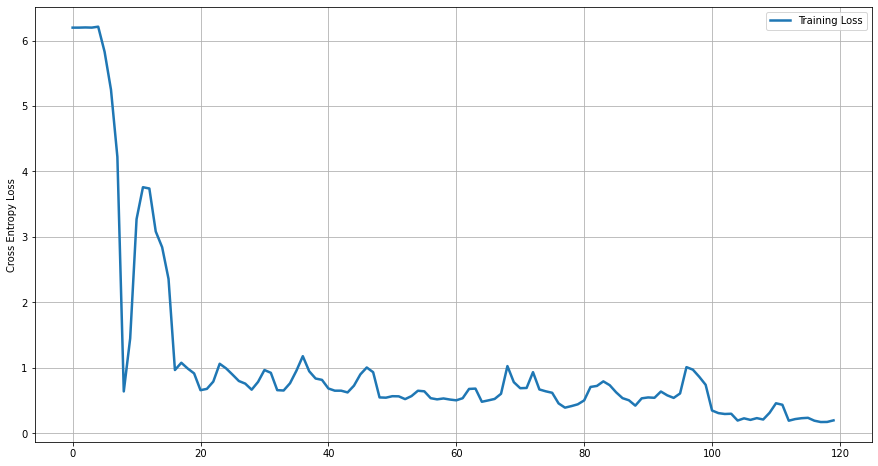

<Figure size 432x288 with 0 Axes>

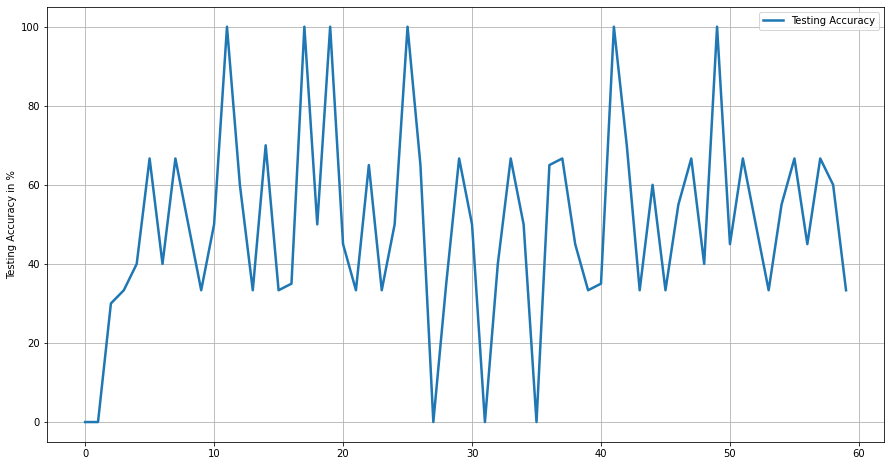

In [18]:
# Download the training and testing data
mini_batch = 20
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn2 = CNN()
if device.type == "cuda":
    cnn2.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn2.parameters(), lr = 0.01)

# Train the model
num_epochs = 30

train_loss, test_accuracy = train(num_epochs, cnn2, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30, mini_batch=20"
expLog_R.loc[1,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R

# Model 3

Epoch [1/40], Step [1/2], Loss: 6.1574
Epoch [1/40], Step [2/2], Loss: 6.1980
Epoch Train Time: 0.30 secs
test_accuracy=  0.0
Epoch [2/40], Step [1/2], Loss: 6.1755
Epoch [2/40], Step [2/2], Loss: 4.8990
Epoch Train Time: 0.48 secs
test_accuracy=  43.47826086956522
Epoch [3/40], Step [1/2], Loss: 1.8473
Epoch [3/40], Step [2/2], Loss: 1.1476
Epoch Train Time: 0.47 secs
test_accuracy=  56.52173913043478
Epoch [4/40], Step [1/2], Loss: 18.5119
Epoch [4/40], Step [2/2], Loss: 5.6510
Epoch Train Time: 0.46 secs
test_accuracy=  43.47826086956522
Epoch [5/40], Step [1/2], Loss: 5.6504
Epoch [5/40], Step [2/2], Loss: 5.0117
Epoch Train Time: 0.45 secs
test_accuracy=  43.47826086956522
Epoch [6/40], Step [1/2], Loss: 2.9347
Epoch [6/40], Step [2/2], Loss: 2.7541
Epoch Train Time: 0.45 secs
test_accuracy=  56.52173913043478
Epoch [7/40], Step [1/2], Loss: 1.5520
Epoch [7/40], Step [2/2], Loss: 1.4636
Epoch Train Time: 0.44 secs
test_accuracy=  43.47826086956522
Epoch [8/40], Step [1/2], Loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13


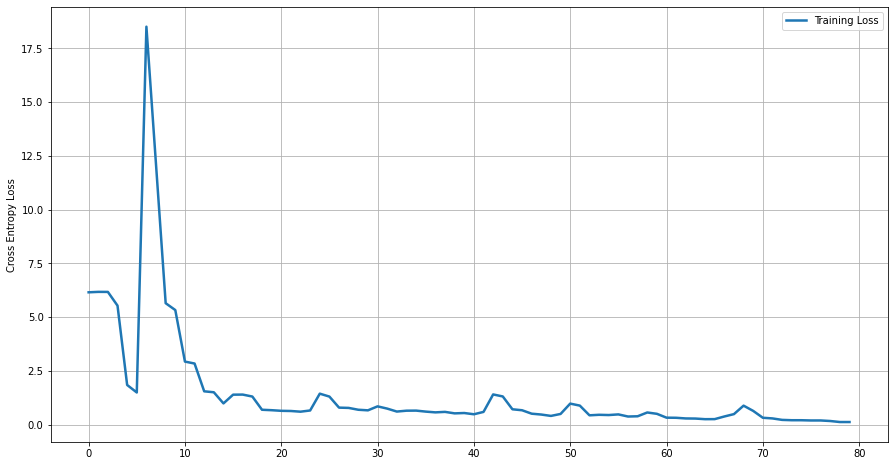

<Figure size 432x288 with 0 Axes>

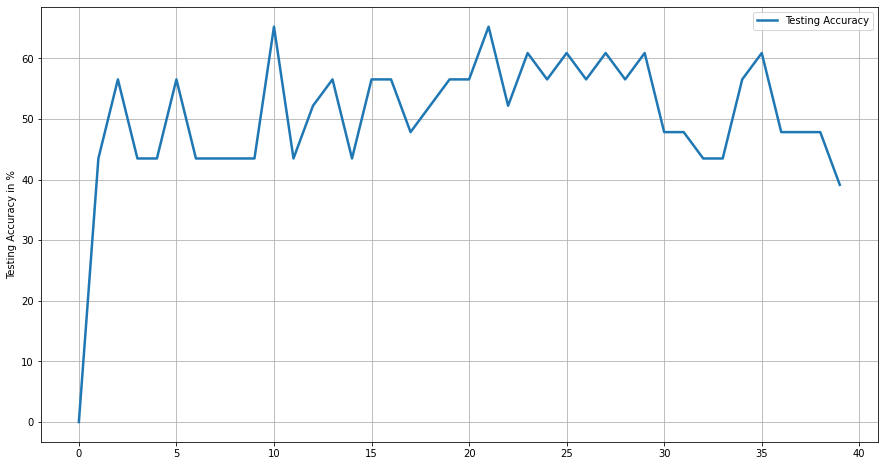

In [11]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn3 = CNN()
if device.type == "cuda":
    cnn3.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn3.parameters(), lr = 0.01, momentum=0.3)

# Train the model
num_epochs = 40

train_loss, test_accuracy = train(num_epochs, cnn3, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40, mini_batch=50"
expLog_R.loc[2,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R

# Model 4

Epoch [1/40], Step [1/3], Loss: 6.1826
Epoch [1/40], Step [2/3], Loss: 6.1734
Epoch [1/40], Step [3/3], Loss: 6.1770
Epoch Train Time: 0.33 secs
test_accuracy=  0.0
Epoch [2/40], Step [1/3], Loss: 6.1773
Epoch [2/40], Step [2/3], Loss: 5.2992
Epoch [2/40], Step [3/3], Loss: 3.8482
Epoch Train Time: 0.53 secs
test_accuracy=  43.47826086956522
Epoch [3/40], Step [1/3], Loss: 3.6521
Epoch [3/40], Step [2/3], Loss: 2.9824
Epoch [3/40], Step [3/3], Loss: 2.0369
Epoch Train Time: 0.52 secs
test_accuracy=  43.47826086956522
Epoch [4/40], Step [1/3], Loss: 0.7755
Epoch [4/40], Step [2/3], Loss: 0.8082
Epoch [4/40], Step [3/3], Loss: 2.0007
Epoch Train Time: 0.50 secs
test_accuracy=  56.52173913043478
Epoch [5/40], Step [1/3], Loss: 2.0067
Epoch [5/40], Step [2/3], Loss: 1.7002
Epoch [5/40], Step [3/3], Loss: 0.4287
Epoch Train Time: 0.49 secs
test_accuracy=  56.52173913043478
Epoch [6/40], Step [1/3], Loss: 0.6907
Epoch [6/40], Step [2/3], Loss: 1.0833
Epoch [6/40], Step [3/3], Loss: 2.2005
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13
3,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.054,47.826


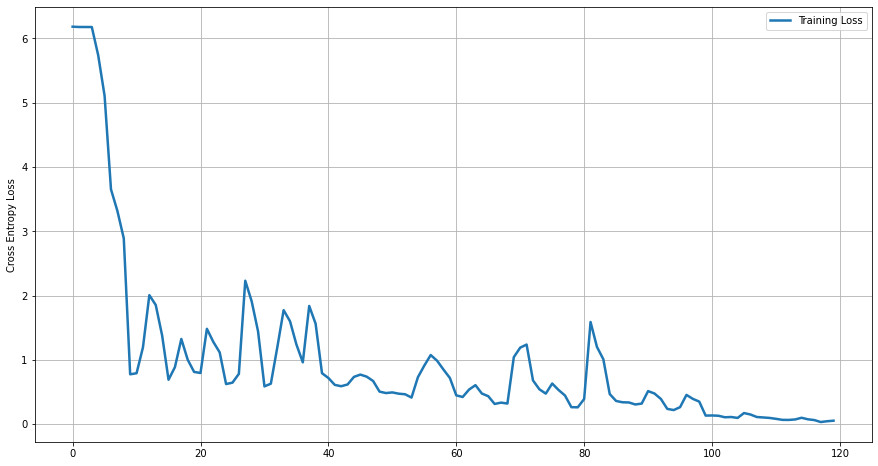

<Figure size 432x288 with 0 Axes>

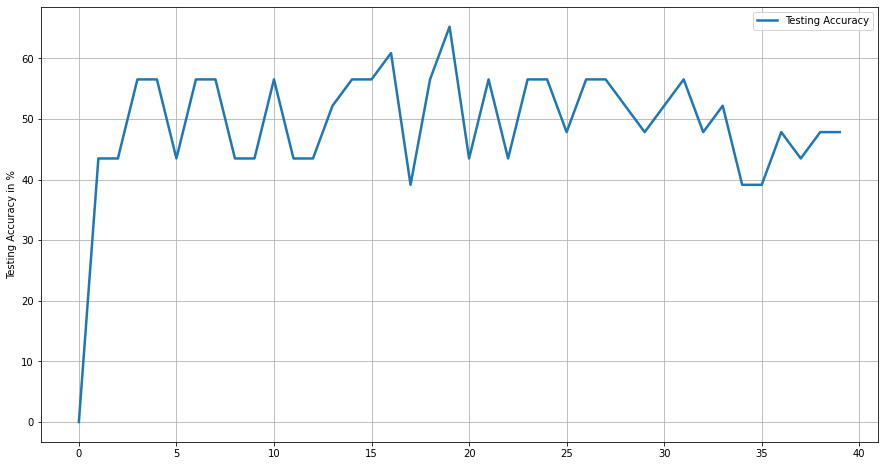

In [12]:
# Download the training and testing data
mini_batch = 35
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn4 = CNN()
if device.type == "cuda":
    cnn4.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn4.parameters(), lr = 0.01)

# Train the model
num_epochs = 40

train_loss, test_accuracy = train(num_epochs, cnn4, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40, mini_batch=35"
expLog_R.loc[3,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R



# Model 5

Epoch [1/30], Step [1/3], Loss: 6.2161
Epoch [1/30], Step [2/3], Loss: 6.2167
Epoch [1/30], Step [3/3], Loss: 6.2425
Epoch Train Time: 0.29 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/3], Loss: 6.2433
Epoch [2/30], Step [2/3], Loss: 5.7449
Epoch [2/30], Step [3/3], Loss: 4.8223
Epoch Train Time: 0.55 secs
test_accuracy=  69.56521739130434
Epoch [3/30], Step [1/3], Loss: 1.8911
Epoch [3/30], Step [2/3], Loss: 1.0819
Epoch [3/30], Step [3/3], Loss: 10.9624
Epoch Train Time: 0.53 secs
test_accuracy=  43.47826086956522
Epoch [4/30], Step [1/3], Loss: 3.7499
Epoch [4/30], Step [2/3], Loss: 2.5191
Epoch [4/30], Step [3/3], Loss: 2.2704
Epoch Train Time: 0.53 secs
test_accuracy=  43.47826086956522
Epoch [5/30], Step [1/3], Loss: 1.2591
Epoch [5/30], Step [2/3], Loss: 0.9362
Epoch [5/30], Step [3/3], Loss: 0.6670
Epoch Train Time: 0.55 secs
test_accuracy=  56.52173913043478
Epoch [6/30], Step [1/3], Loss: 0.9748
Epoch [6/30], Step [2/3], Loss: 1.5936
Epoch [6/30], Step [3/3], Loss: 0.7793
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13
3,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.054,47.826
4,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.191,52.174


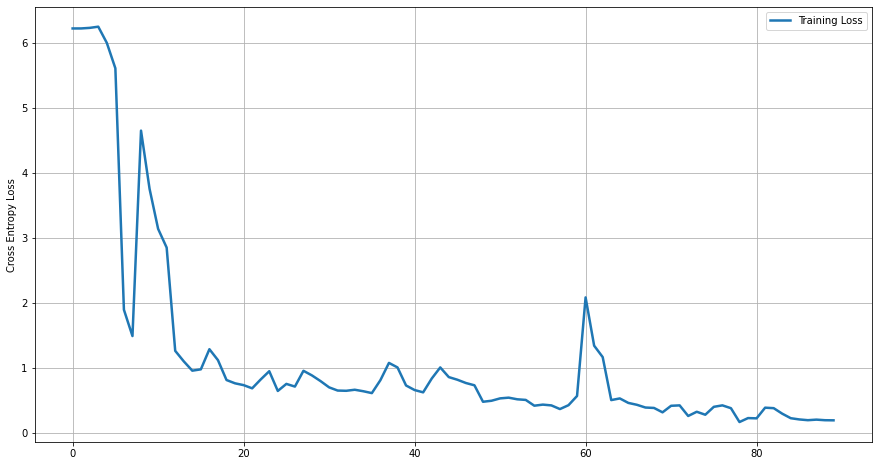

<Figure size 432x288 with 0 Axes>

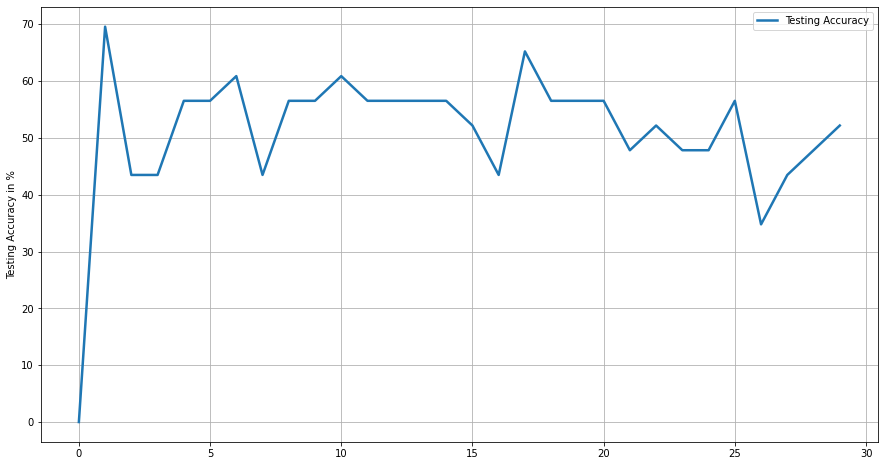

In [13]:
##Lets focus on zero loss:
# Download the training and testing data
mini_batch = 30
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn5 = CNN()
if device.type == "cuda":
    cnn5.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn5.parameters(), lr = 0.01, momentum=0.3)

# Train the model
num_epochs = 30

train_loss, test_accuracy = train(num_epochs, cnn5, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30, mini_batch=30, momentum=0.3"
expLog_R.loc[4,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R


# Model 6

Epoch [1/30], Step [1/3], Loss: 6.1663
Epoch [1/30], Step [2/3], Loss: 6.1725
Epoch [1/30], Step [3/3], Loss: 6.1681
Epoch Train Time: 0.28 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/3], Loss: 6.1686
Epoch [2/30], Step [2/3], Loss: 5.2125
Epoch [2/30], Step [3/3], Loss: 2.8989
Epoch Train Time: 0.51 secs
test_accuracy=  43.47826086956522
Epoch [3/30], Step [1/3], Loss: 1.0123
Epoch [3/30], Step [2/3], Loss: 9.6271
Epoch [3/30], Step [3/3], Loss: 3.9276
Epoch Train Time: 0.54 secs
test_accuracy=  43.47826086956522
Epoch [4/30], Step [1/3], Loss: 2.2714
Epoch [4/30], Step [2/3], Loss: 2.0666
Epoch [4/30], Step [3/3], Loss: 1.4776
Epoch Train Time: 0.54 secs
test_accuracy=  65.21739130434783
Epoch [5/30], Step [1/3], Loss: 0.7156
Epoch [5/30], Step [2/3], Loss: 0.7852
Epoch [5/30], Step [3/3], Loss: 0.9503
Epoch Train Time: 0.55 secs
test_accuracy=  43.47826086956522
Epoch [6/30], Step [1/3], Loss: 0.8821
Epoch [6/30], Step [2/3], Loss: 0.7656
Epoch [6/30], Step [3/3], Loss: 0.6774
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13
3,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.054,47.826
4,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.191,52.174
5,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.074,47.826


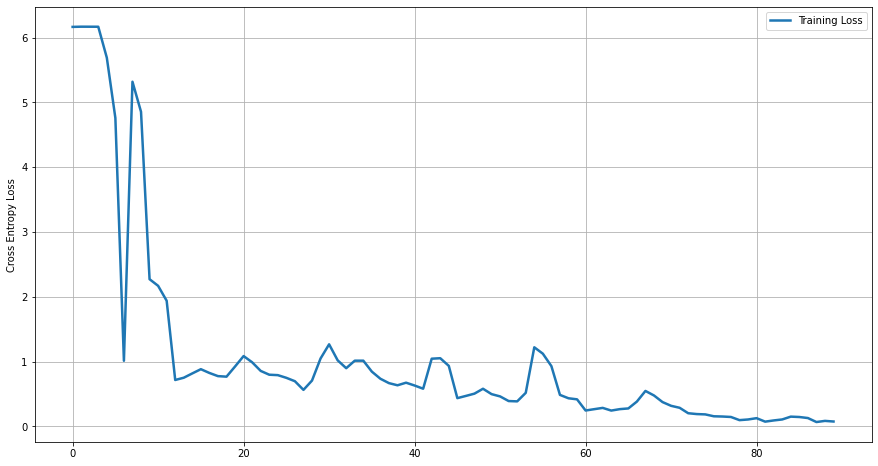

<Figure size 432x288 with 0 Axes>

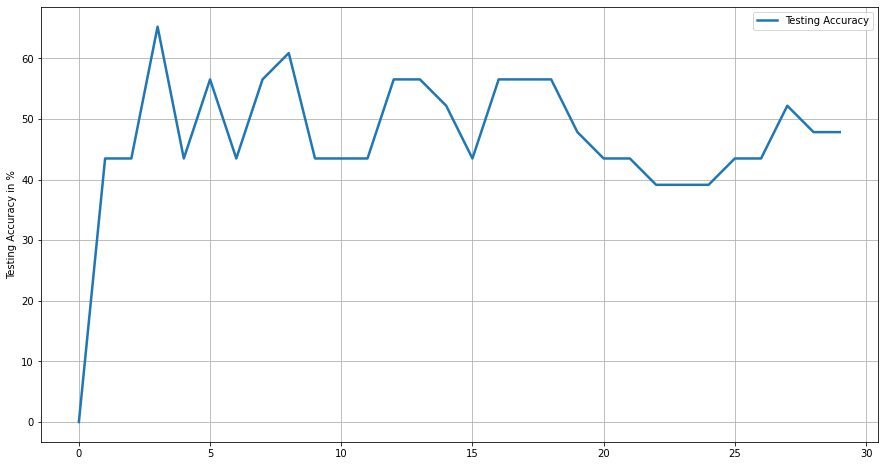

In [14]:
##Lets focus on zero loss:
# Download the training and testing data
mini_batch = 30
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn6 = CNN()
if device.type == "cuda":
    cnn6.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn6.parameters(), lr = 0.01, momentum=0.2)

# Train the model
num_epochs = 30

train_loss, test_accuracy = train(num_epochs, cnn6, train_loader, test_loader, mini_batch)


#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30, mini_batch=30, momentum=0.2"
expLog_R.loc[5,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R



# Model 7

Epoch [1/30], Step [1/3], Loss: 6.2097
Epoch [1/30], Step [2/3], Loss: 6.2051
Epoch [1/30], Step [3/3], Loss: 6.2008
Epoch Train Time: 0.27 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/3], Loss: 6.2108
Epoch [2/30], Step [2/3], Loss: 4.6824
Epoch [2/30], Step [3/3], Loss: 2.0032
Epoch Train Time: 0.51 secs
test_accuracy=  43.47826086956522
Epoch [3/30], Step [1/3], Loss: 2.3284
Epoch [3/30], Step [2/3], Loss: 3.3959
Epoch [3/30], Step [3/3], Loss: 1.9539
Epoch Train Time: 0.55 secs
test_accuracy=  43.47826086956522
Epoch [4/30], Step [1/3], Loss: 0.7851
Epoch [4/30], Step [2/3], Loss: 4.7394
Epoch [4/30], Step [3/3], Loss: 3.3252
Epoch Train Time: 0.53 secs
test_accuracy=  43.47826086956522
Epoch [5/30], Step [1/3], Loss: 3.0373
Epoch [5/30], Step [2/3], Loss: 3.1235
Epoch [5/30], Step [3/3], Loss: 1.8485
Epoch Train Time: 0.54 secs
test_accuracy=  56.52173913043478
Epoch [6/30], Step [1/3], Loss: 0.8905
Epoch [6/30], Step [2/3], Loss: 0.8328
Epoch [6/30], Step [3/3], Loss: 0.8364
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13
3,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.054,47.826
4,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.191,52.174
5,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.074,47.826
6,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.164,34.783


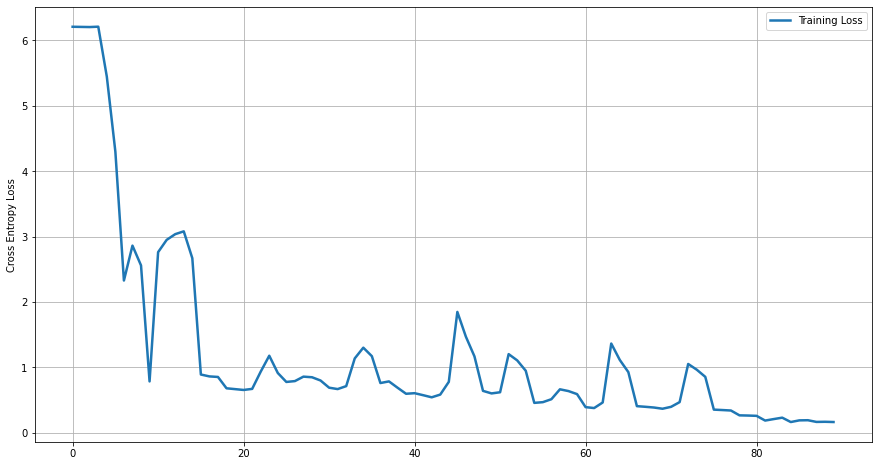

<Figure size 432x288 with 0 Axes>

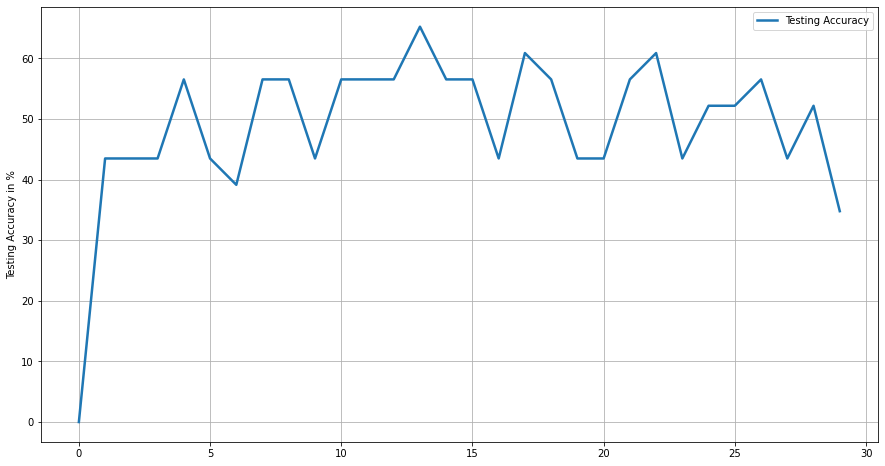

In [15]:
# Download the training and testing data
mini_batch = 30
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn7 = CNN()
if device.type == "cuda":
    cnn7.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn7.parameters(), lr = 0.01, momentum=0.02)

# Train the model
num_epochs = 30
train_loss, test_accuracy = train(num_epochs, cnn7, train_loader, test_loader, mini_batch)

#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30, mini_batch=30, momentum=0.02"
expLog_R.loc[6,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R



# Model 8

Epoch [1/40], Step [1/2], Loss: 6.2153
Epoch [1/40], Step [2/2], Loss: 6.2121
Epoch Train Time: 0.28 secs
test_accuracy=  0.0
Epoch [2/40], Step [1/2], Loss: 6.2220
Epoch [2/40], Step [2/2], Loss: 5.2762
Epoch Train Time: 0.49 secs
test_accuracy=  43.47826086956522
Epoch [3/40], Step [1/2], Loss: 3.4066
Epoch [3/40], Step [2/2], Loss: 1.0019
Epoch Train Time: 0.50 secs
test_accuracy=  56.52173913043478
Epoch [4/40], Step [1/2], Loss: 2.1721
Epoch [4/40], Step [2/2], Loss: 6.1310
Epoch Train Time: 0.48 secs
test_accuracy=  43.47826086956522
Epoch [5/40], Step [1/2], Loss: 4.1023
Epoch [5/40], Step [2/2], Loss: 2.1064
Epoch Train Time: 0.45 secs
test_accuracy=  56.52173913043478
Epoch [6/40], Step [1/2], Loss: 0.8552
Epoch [6/40], Step [2/2], Loss: 0.7042
Epoch Train Time: 0.46 secs
test_accuracy=  43.47826086956522
Epoch [7/40], Step [1/2], Loss: 1.7307
Epoch [7/40], Step [2/2], Loss: 2.5275
Epoch Train Time: 0.43 secs
test_accuracy=  43.47826086956522
Epoch [8/40], Step [1/2], Loss: 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
0,"loss: CXE, optimizer: SGD, lr: 0.001, epoch: 3...",0.559,56.522
2,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.124,39.13
3,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.054,47.826
4,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.191,52.174
5,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.074,47.826
6,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 30...",0.164,34.783
7,"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40...",0.5,56.522


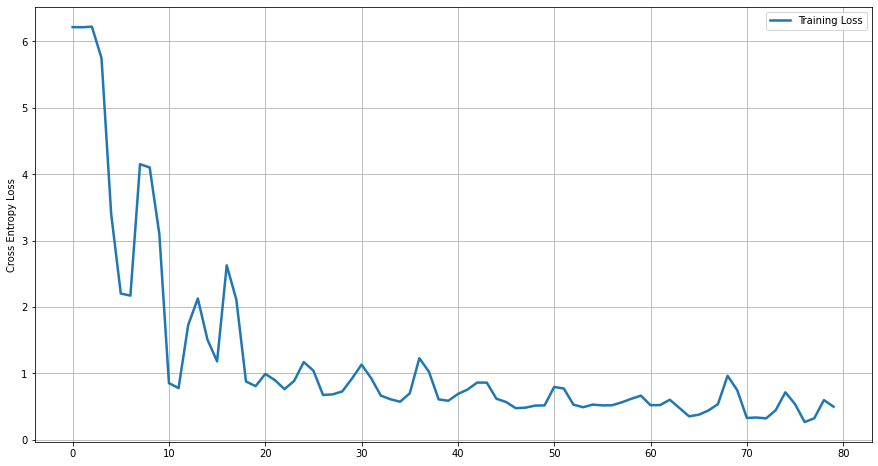

<Figure size 432x288 with 0 Axes>

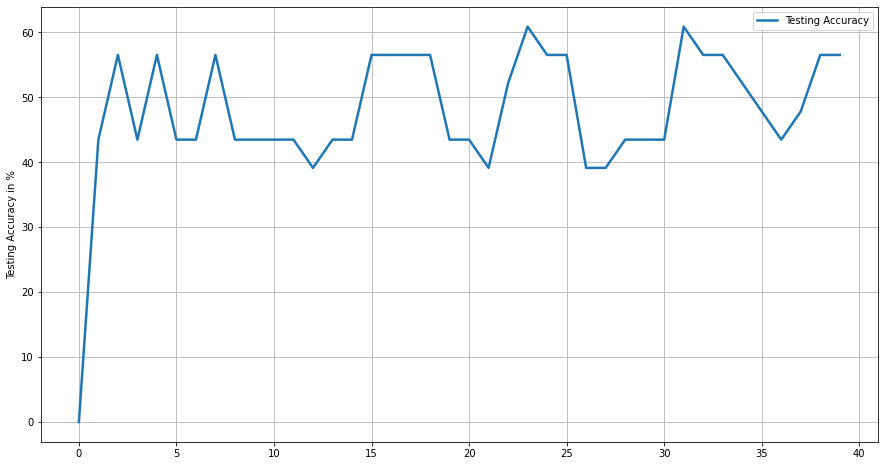

In [16]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn8 = CNN()
if device.type == "cuda":
    cnn8.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn8.parameters(), lr = 0.01, momentum=0.02)

# Train the model
num_epochs = 40

train_loss, test_accuracy = train(num_epochs, cnn8, train_loader, test_loader, mini_batch)

#Logging the experiments
exp_name = f"loss: CXE, optimizer: SGD, lr: 0.01, epoch: 40, mini_batch=50, momentum=0.02"
expLog_R.loc[7,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R



# Model 9


Epoch [1/30], Step [1/3], Loss: 6.1492
Epoch [1/30], Step [2/3], Loss: 6.1591
Epoch [1/30], Step [3/3], Loss: 6.1707
Epoch Train Time: 11.83 secs
test_accuracy=  4.3478260869565215
Epoch [2/30], Step [1/3], Loss: 6.1608
Epoch [2/30], Step [2/3], Loss: 722.0380
Epoch [2/30], Step [3/3], Loss: 1644.6072
Epoch Train Time: 0.77 secs
test_accuracy=  56.52173913043478
Epoch [3/30], Step [1/3], Loss: 13.8190
Epoch [3/30], Step [2/3], Loss: 5.4250
Epoch [3/30], Step [3/3], Loss: 5.1476
Epoch Train Time: 0.69 secs
test_accuracy=  56.52173913043478
Epoch [4/30], Step [1/3], Loss: 4.7080
Epoch [4/30], Step [2/3], Loss: 3.7438
Epoch [4/30], Step [3/3], Loss: 2.2118
Epoch Train Time: 0.69 secs
test_accuracy=  56.52173913043478
Epoch [5/30], Step [1/3], Loss: 1.9601
Epoch [5/30], Step [2/3], Loss: 2.4570
Epoch [5/30], Step [3/3], Loss: 1.5330
Epoch Train Time: 0.69 secs
test_accuracy=  56.52173913043478
Epoch [6/30], Step [1/3], Loss: 2.3389
Epoch [6/30], Step [2/3], Loss: 2.7419
Epoch [6/30], Step 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
8,"loss: CXE, optimizer: Adam, lr: 0.01, epoch: 3...",0.702,43.478


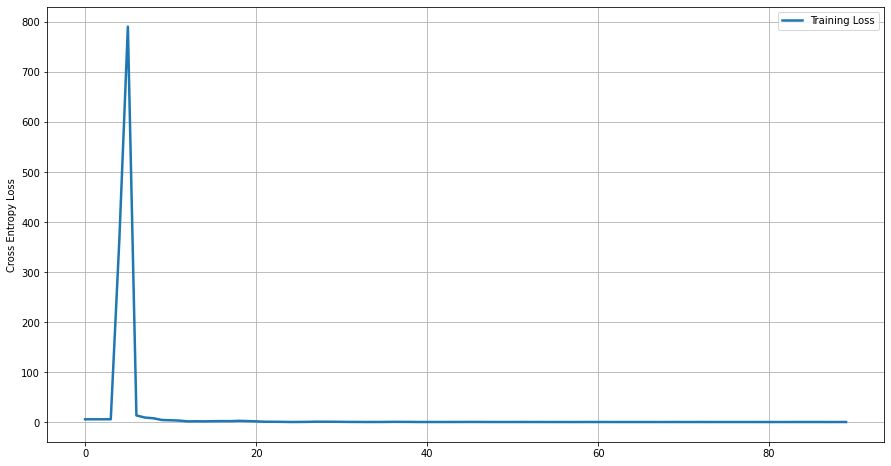

<Figure size 432x288 with 0 Axes>

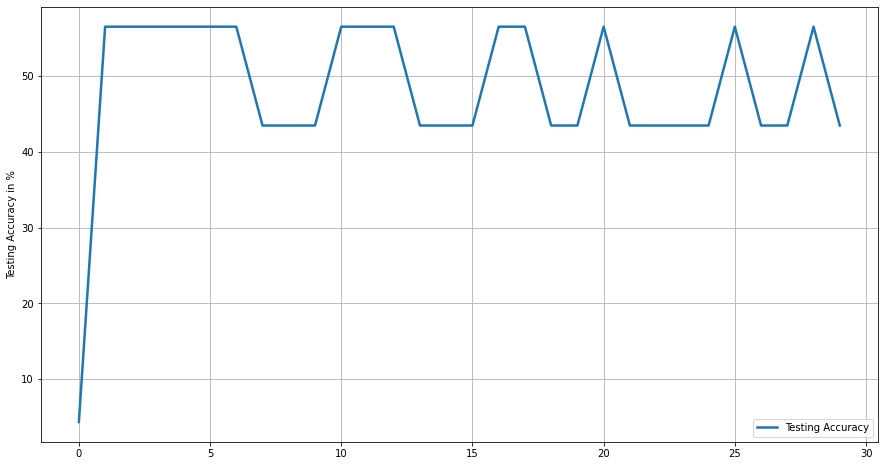

In [9]:
# Download the training and testing data
mini_batch = 30
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn9 = CNN()
if device.type == "cuda":
    cnn9.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(cnn9.parameters(), lr = 0.01)


# Train the model
num_epochs = 30

train_loss, test_accuracy = train(num_epochs, cnn9, train_loader, test_loader, mini_batch)

#Logging the experiments
exp_name = f"loss: CXE, optimizer: Adam, lr: 0.01, epoch: 30, mini_batch=30"
expLog_R.loc[8,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R


# Model 10

Epoch [1/30], Step [1/2], Loss: 6.2094
Epoch [1/30], Step [2/2], Loss: 6.2080
Epoch Train Time: 0.26 secs
test_accuracy=  0.0
Epoch [2/30], Step [1/2], Loss: 6.2117
Epoch [2/30], Step [2/2], Loss: 4.0994
Epoch Train Time: 0.60 secs
test_accuracy=  56.52173913043478
Epoch [3/30], Step [1/2], Loss: 33.4282
Epoch [3/30], Step [2/2], Loss: 15.8642
Epoch Train Time: 0.58 secs
test_accuracy=  56.52173913043478
Epoch [4/30], Step [1/2], Loss: 6.6270
Epoch [4/30], Step [2/2], Loss: 0.6853
Epoch Train Time: 0.57 secs
test_accuracy=  43.47826086956522
Epoch [5/30], Step [1/2], Loss: 1.0533
Epoch [5/30], Step [2/2], Loss: 1.6899
Epoch Train Time: 0.55 secs
test_accuracy=  43.47826086956522
Epoch [6/30], Step [1/2], Loss: 2.1701
Epoch [6/30], Step [2/2], Loss: 2.3713
Epoch Train Time: 0.55 secs
test_accuracy=  43.47826086956522
Epoch [7/30], Step [1/2], Loss: 1.7976
Epoch [7/30], Step [2/2], Loss: 1.3820
Epoch Train Time: 0.55 secs
test_accuracy=  43.47826086956522
Epoch [8/30], Step [1/2], Loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
8,"loss: CXE, optimizer: Adam, lr: 0.01, epoch: 3...",0.702,43.478
9,"loss: CXE, opt: Adam, lr: 0.001, eps:1e-08 epo...",0.001,52.174


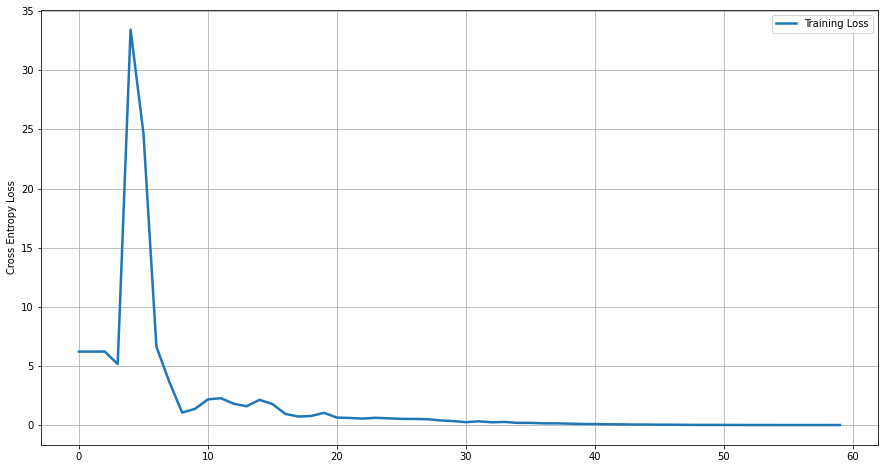

<Figure size 432x288 with 0 Axes>

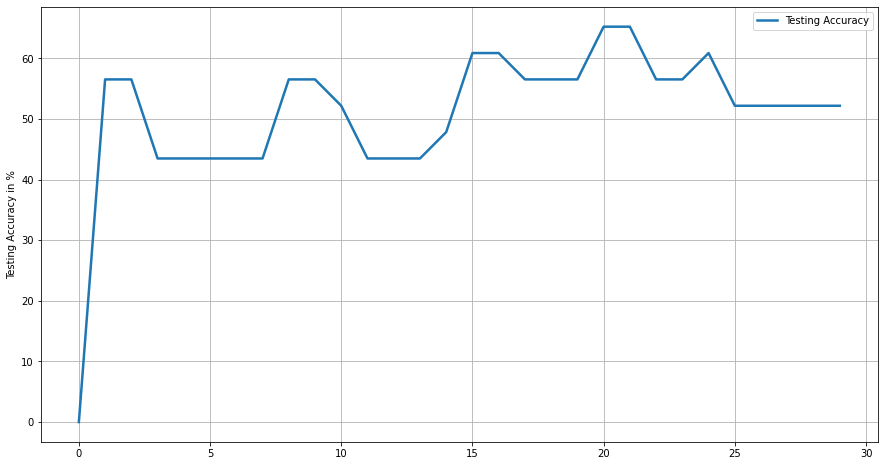

In [10]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn10 = CNN()
if device.type == "cuda":
    cnn10.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(cnn10.parameters(), lr = 0.001, eps=1e-08)

# Train the model
num_epochs = 30

train_loss, test_accuracy = train(num_epochs, cnn10, train_loader, test_loader, mini_batch)

#Logging the experiments
exp_name = f"loss: CXE, opt: Adam, lr: 0.001, eps:1e-08 epoch: 30, mini_batch=50"
expLog_R.loc[9,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R

# Model 11

Epoch [1/10], Step [1/2], Loss: 6.2266
Epoch [1/10], Step [2/2], Loss: 6.2299
Epoch Train Time: 0.26 secs
test_accuracy=  0.0
Epoch [2/10], Step [1/2], Loss: 6.2240
Epoch [2/10], Step [2/2], Loss: 245.2419
Epoch Train Time: 0.54 secs
test_accuracy=  56.52173913043478
Epoch [3/10], Step [1/2], Loss: 815.2668
Epoch [3/10], Step [2/2], Loss: 12.8128
Epoch Train Time: 0.55 secs
test_accuracy=  56.52173913043478
Epoch [4/10], Step [1/2], Loss: 5.5534
Epoch [4/10], Step [2/2], Loss: 5.2236
Epoch Train Time: 0.55 secs
test_accuracy=  56.52173913043478
Epoch [5/10], Step [1/2], Loss: 4.6255
Epoch [5/10], Step [2/2], Loss: 3.7931
Epoch Train Time: 0.55 secs
test_accuracy=  56.52173913043478
Epoch [6/10], Step [1/2], Loss: 2.6868
Epoch [6/10], Step [2/2], Loss: 2.4278
Epoch Train Time: 0.54 secs
test_accuracy=  56.52173913043478
Epoch [7/10], Step [1/2], Loss: 2.0508
Epoch [7/10], Step [2/2], Loss: 2.2646
Epoch Train Time: 0.54 secs
test_accuracy=  56.52173913043478
Epoch [8/10], Step [1/2], Los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,exp_name,Loss,Accuracy
8,"loss: CXE, optimizer: Adam, lr: 0.01, epoch: 3...",0.702,43.478
9,"loss: CXE, opt: Adam, lr: 0.001, eps:1e-08 epo...",0.001,52.174
10,"loss: CXE, opt: Adam, lr: 0.01, eps:1e-08 epoc...",2.166,56.522


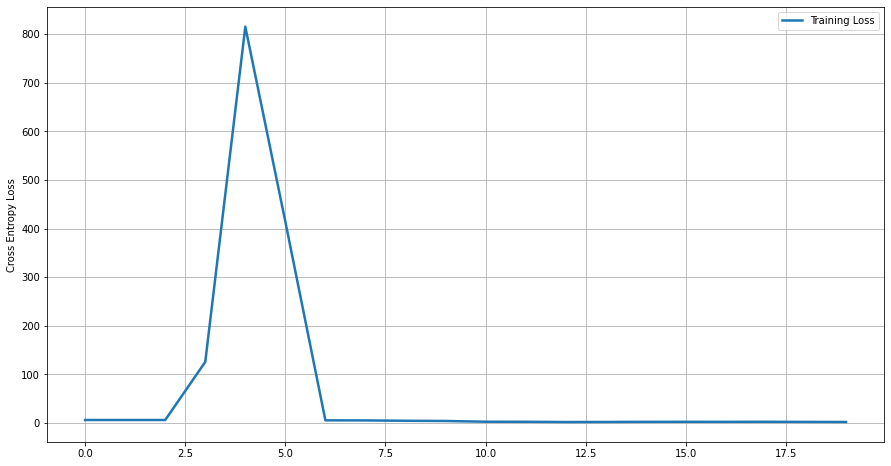

<Figure size 432x288 with 0 Axes>

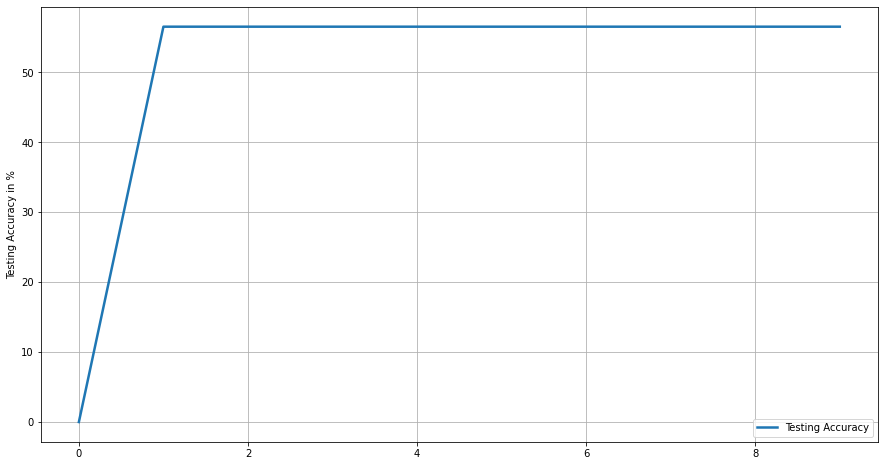

In [11]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn11 = CNN()
if device.type == "cuda":
    cnn11.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(cnn11.parameters(), lr = 0.01, eps=1e-08)

# Train the model
num_epochs = 10

train_loss, test_accuracy = train(num_epochs, cnn11, train_loader, test_loader, mini_batch)

#Logging the experiments
exp_name = f"loss: CXE, opt: Adam, lr: 0.01, eps:1e-08 epoch: 10, mini_batch=50"
expLog_R.loc[10,:3] = [f"{exp_name}"] + [f"{np.round(train_loss[-1],3)}"] + [f"{np.round(test_accuracy[-1],3)}"]
expLog_R

In [12]:
#%%shell
#jupyter nbconvert --to html /content/Group_19_CNN.ipynb
